In [2]:
import os
import cv2
import numpy as np
import string
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, LSTM 

from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax

from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm
from collections import Counter

from PIL import Image

In [3]:
def generate_data(path):
  # Function that splits training path and annotations in 2 different lists.
  _path = []
  _label = []
  with open(path) as _data:
    for line in _data:
      temp = np.array(line.split())
      _path.append(temp[0])
      _label.append(temp[1])
  return _path, _label

In [4]:
test_path, test_label = generate_data("/kaggle/input/hindi-words-dataset/test.txt")

In [14]:
temp_vocab = []
with open("/kaggle/input/hindi-words-dataset/hindi_vocab.txt") as hindi_voc:
  for char in hindi_voc:
    temp = np.array(char.split("\n"))
    temp_vocab.append(temp[0])
vocab = set("".join(map(str, temp_vocab)))

char_list = sorted(vocab)

In [5]:
# input with shape of height=32 and width=128
inputs = Input(shape=(32, 128, 1))

conv_1 = Conv2D(16, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(32, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_2)
conv_4 = Conv2D(64, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(64, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(64, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

outputs = Dense(113, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [7]:
act_model.load_weights('/kaggle/input/model/keras/model/1/Hindi_OCR_Model.keras')

In [8]:
def pre_process_image(path):

  img = cv2.cvtColor(cv2.imread("/kaggle/input/hindi-words-dataset/HindiSeg/"+path), cv2.COLOR_BGR2GRAY)
  # img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
  ### actually returns h, w
  h, w = img.shape

  ### if height less than 32
  if h < 32:
    add_zeros = np.ones((32-h, w)) * 255
    img = np.concatenate((img, add_zeros))
    h = 32

  ## if width less than 128
  if w < 128:
    add_zeros = np.ones((h, 128-w)) * 255
    img = np.concatenate((img, add_zeros), axis=1)
    w = 128

  ### if width is greater than 128 or height greater than 32
  if w > 128 or h > 32:
    img = cv2.resize(img, (128, 32))


  img = np.expand_dims(img , axis = 2)

  # Normalize each image
  img = img / 255.

  return img

In [9]:
def predict_output(img):
    # Predict outputs using the pre-trained model
    prediction = act_model.predict(np.array([img]))
    
    # Use CTC decoder to get text
    out = K.get_value(K.ctc_decode(
        prediction,
        input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
        greedy=True
    )[0][0])

    # Decode the final text into a single string
    decoded_text = ''
    for x in out:
        for p in x:
            if int(p) != -1:
                decoded_text += char_list[int(p)]
    
    return decoded_text

In [11]:
# First, install Levenshtein if needed
!pip install Levenshtein

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 56.7 MB/s eta 0:00:00:00:01


In [12]:
import Levenshtein as lev

# Function to calculate Character Error Rate (CER)
def calculate_cer(predicted_text, true_text):
    # Get the Levenshtein distance between predicted and actual text
    edit_distance = lev.distance(predicted_text, true_text)
    
    # CER is calculated as the edit distance divided by the length of the actual text
    cer = edit_distance / len(true_text)
    
    return cer

In [ ]:
from IPython.display import display
from random import randrange

# Create lists to store the predicted and actual text
y_pred = []
y_true = test_label # Assuming `test_label` contains the actual ground truth text

# Generate predictions and compute CER
cer_list = []
for i in range(len(test_path)):

    index = randrange(len(test_path))
    # Pre-process the image and get the predicted text
    test_img = pre_process_image(test_path[index])
    predicted_text = predict_output(test_img)
    
    # Get the actual text
    actual_text = test_label[index]
    
    # Calculate CER
    cer = calculate_cer(predicted_text, actual_text)
    cer_list.append(cer)

    # Store predicted text for further analysis
    y_pred.append(predicted_text)
    
    print(predicted_text, y_true[index])
    


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
चौचारण चौपारण
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
माहिि माहिर
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
चढढ़़ाई चढ़ाई
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
पहेली पहेली
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
संघर्ष संघर्ष
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
वैदियां वेदियां
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
सबेध संबोधि
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
रंगमंच रंगमंच
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
घरषटिरा घटिया
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
अम्द्र आन्ध्र
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
अरछोलनों आयोजनों
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
ब्द्ं वाईफ
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
रिनेर्शरता निर्भरता
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
पिफल्म पिफल्म
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
उकावना उतावला
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
सुरिंदर सुरिंदर
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
बाल-बान बाल-बाल
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
फ्रोल्नीवर फोल्लोवर
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
चोपडा चोपड़ा
1/1 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
युकांकी एकांकी
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
दयनीय दयनीय
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
भोर थोर
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
एन्ॉय एन्जॉय
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
हव्याे हत्याएं
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
डायते ज्ञापित
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
सुन सुन
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
चिला चित्त
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
फेरक प्रेरक
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
दिल्ली दिल्ली
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
गादा गदा
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
पौल पौन
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
दॉडी बॉडी
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
लम्े लम्बे
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
परिर्वन परिर्वन
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
दर्बारियों दरबारियों
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
दीजिये। दीजिये।
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
प्रियका प्रियंका
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
बरांसदे बरामदे
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
धुमाखीं घुमारवीं
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
अपताशंकि्त अतारांकित
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
झल्ला झल्ला
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
स्वजातीस स्वजातीय
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
वंटचर्धित बहुचर्चित
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
बैलें बेंलें
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
दिये दिये
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
किर्णो किरणो
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
आद्धबवृत अर्द्ववृत्त
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
नगाडा नगाड़ा
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
कानपुा कानपुर
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
जनगा़ जलगढ़
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
अव्वा सबा
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
बंदरों भंडारों
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
विर््ँ मियाँ
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
जनगा़ जलगढ़
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
नसकों नायकों
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
सौ-सों सौ-सौ
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
घु-मतर छू-मंतर
1/1 ━

In [16]:
average_cer = np.mean(cer_list)
print("Average Character Error Rate (CER):", average_cer)

Average Character Error Rate (CER): 0.26565672321575695


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


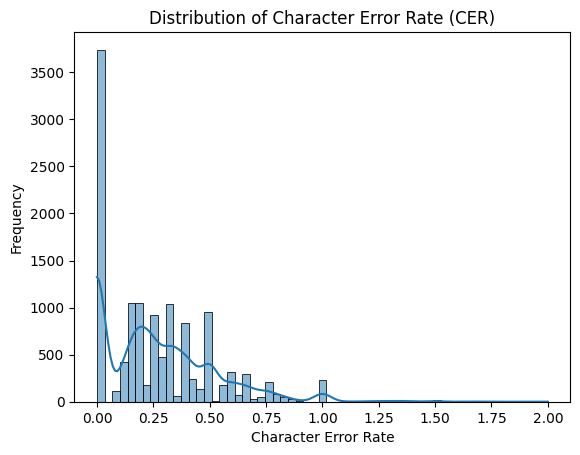

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Levenshtein import distance as levenshtein_distance

sns.histplot(cer_list, kde=True)
plt.title("Distribution of Character Error Rate (CER)")
plt.xlabel("Character Error Rate")
plt.ylabel("Frequency")
plt.show()

In [20]:
def predict_sample_output(img):
    # predict outputs on validation images
    prediction = act_model.predict(np.array([img]))
    ## shape (batch_size, num_timesteps, vocab_size)

    # use CTC decoder
    out = K.get_value(K.ctc_decode(prediction, 
                                   input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                                   greedy=True)[0][0])

    ## get the final text    
    for x in out:

        print("predicted text = ", end = '')

        for p in x:

            if int(p) != -1:
                print(char_list[int(p)], end = '')
        
        print('\n')

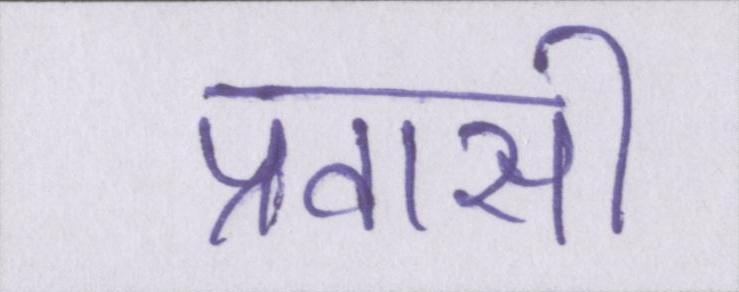



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
predicted text = प्रवासी



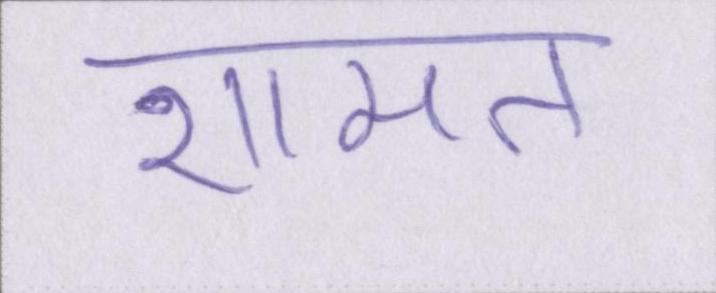



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
predicted text = शामत



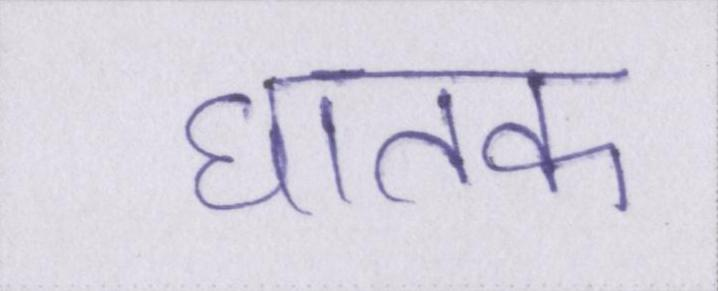



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
predicted text = घातक



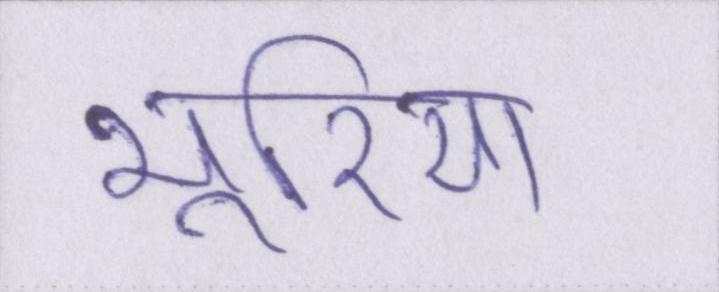



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
predicted text = सूरिा



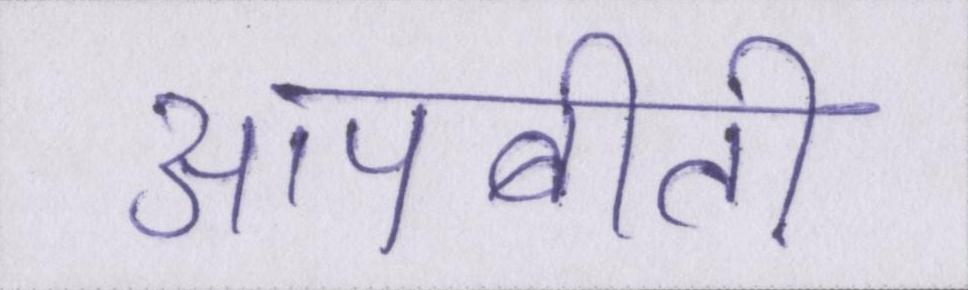



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
predicted text = सपबीती



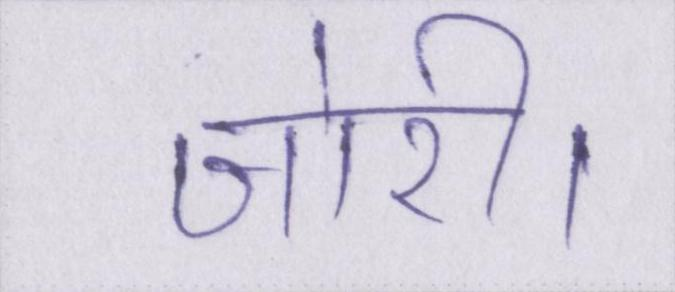



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
predicted text = जोरी।



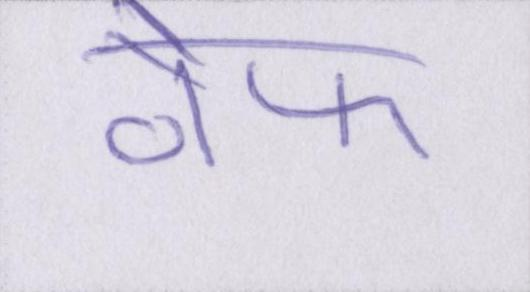



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
predicted text = टेक



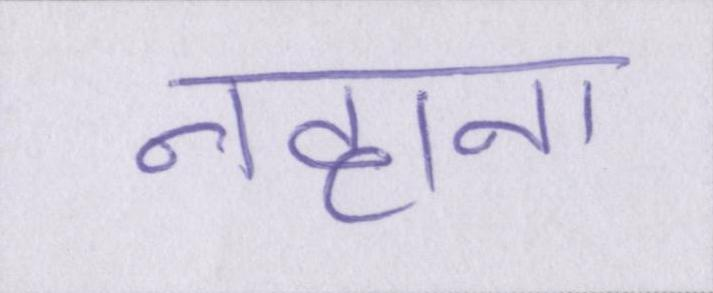



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
predicted text = नक्ाना



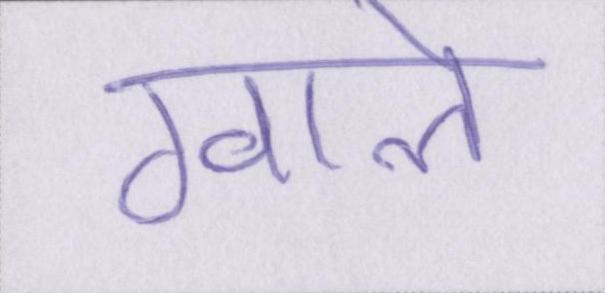



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
predicted text = टवाले



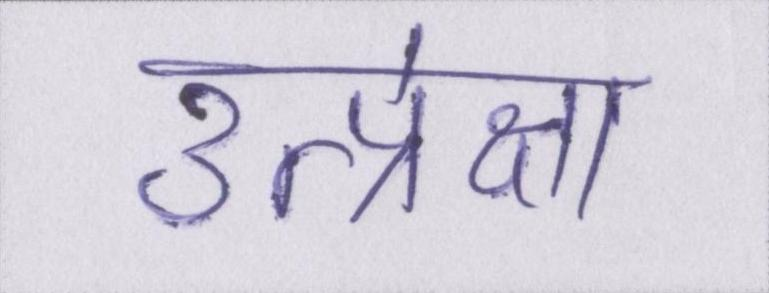



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
predicted text = उ्त्प्रेक्षा



In [21]:
for i in range(10):
    index = randrange(len(test_path))
    im = Image.open("/kaggle/input/hindi-words-dataset/HindiSeg/"+test_path[index])
    display(im)

    print("\n")

    test_img = pre_process_image(test_path[index])
    predict_sample_output(test_img)